<a href="https://www.kaggle.com/code/botaylaamin/arabic-alphabets-sign-language?scriptVersionId=263615838" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import shutil
from io import BytesIO
from PIL import Image, ImageOps, ImageFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array,ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

# Handle truncated image warnings in PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


# *Dataset Path & Parameters*

In [5]:
path = '/kaggle/input/arabic-alphabets-sign-language-dataset-arasl/ArASL_Database_54K_Final/ArASL_Database_54K_Final'
img_size = (224, 224)
batch_size = 32 

# *EDA (Exploratory Data Analysis)*

In [6]:
classes = sorted(os.listdir(path))
num_classes = len(classes)
print("Number of classes:", num_classes)
print("Class indices mapping:", {class_name: idx for idx, class_name in enumerate(classes)})

Number of classes: 32
Class indices mapping: {'ain': 0, 'al': 1, 'aleff': 2, 'bb': 3, 'dal': 4, 'dha': 5, 'dhad': 6, 'fa': 7, 'gaaf': 8, 'ghain': 9, 'ha': 10, 'haa': 11, 'jeem': 12, 'kaaf': 13, 'khaa': 14, 'la': 15, 'laam': 16, 'meem': 17, 'nun': 18, 'ra': 19, 'saad': 20, 'seen': 21, 'sheen': 22, 'ta': 23, 'taa': 24, 'thaa': 25, 'thal': 26, 'toot': 27, 'waw': 28, 'ya': 29, 'yaa': 30, 'zay': 31}


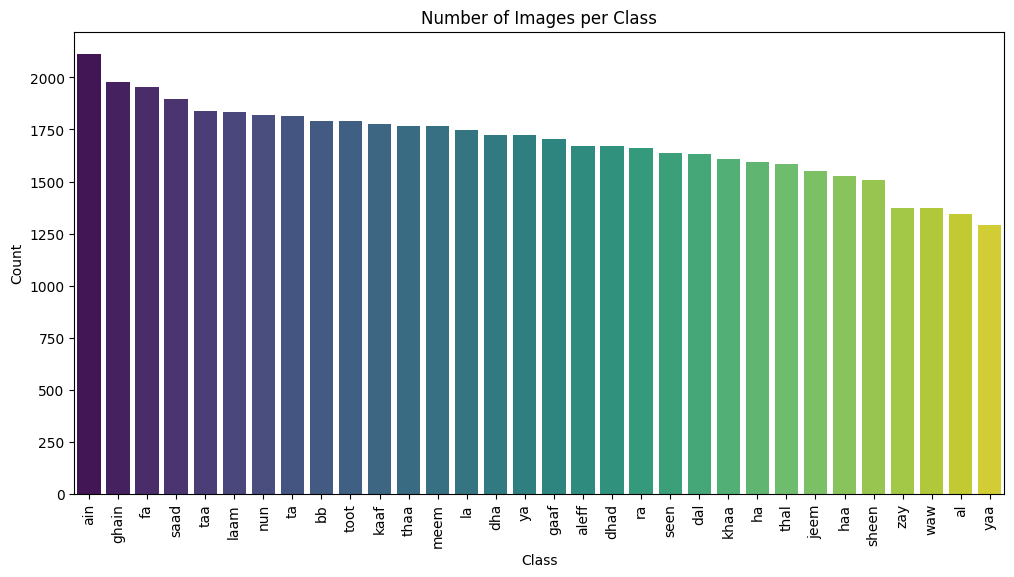

In [7]:
class_counts = {}
for class_name in os.listdir(path):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])
df_counts = df_counts.sort_values("Count", ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=df_counts, x="Class", y="Count", palette="viridis")
plt.xticks(rotation=90)
plt.title("Number of Images per Class")
plt.show()

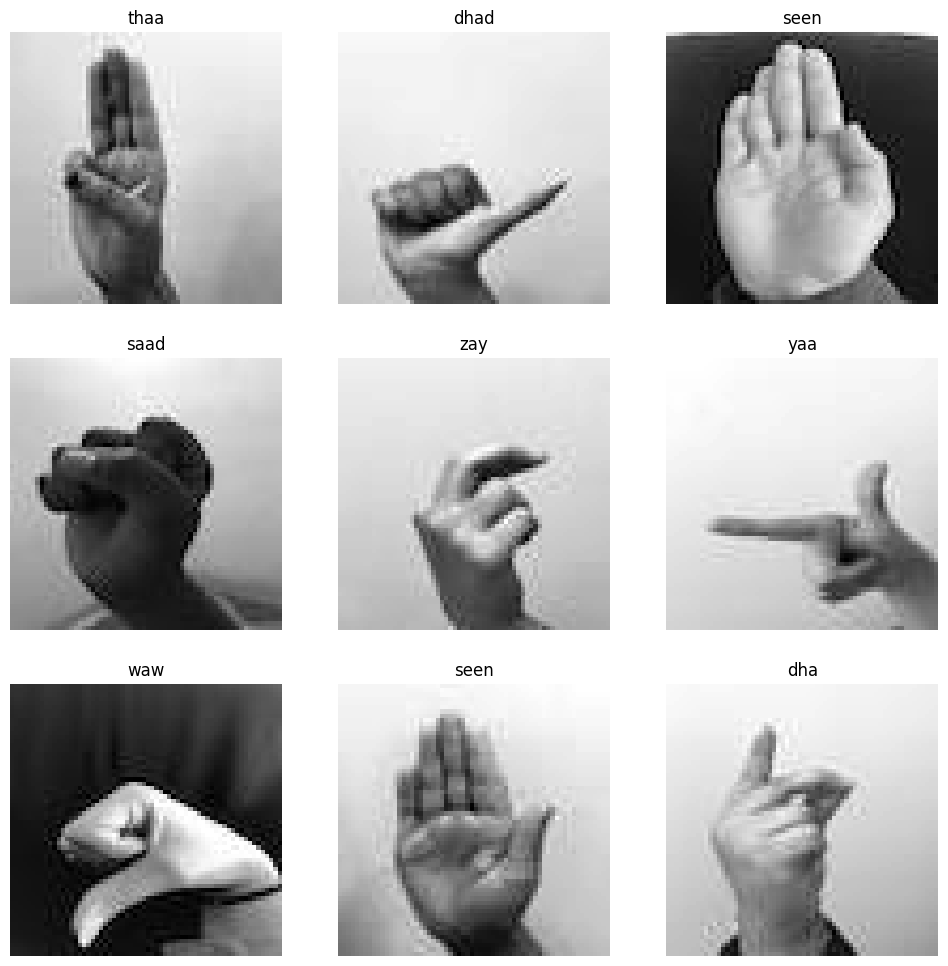

In [8]:
import random
plt.figure(figsize=(12,12))
classes = os.listdir(path)
for i in range(9):
    class_choice = random.choice(classes)
    class_path = os.path.join(path, class_choice)
    img_choice = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_choice)

    img = plt.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(class_choice)
    plt.axis("off")
plt.show()

# *Data Preparation*

In [9]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training data generator
train_data = datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

# Validation data generator
val_data = datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True,
    seed=42
)

print("Classes:", train_data.class_indices)
print("Number of classes:", len(train_data.class_indices))

Found 43252 images belonging to 32 classes.
Found 10797 images belonging to 32 classes.
Classes: {'ain': 0, 'al': 1, 'aleff': 2, 'bb': 3, 'dal': 4, 'dha': 5, 'dhad': 6, 'fa': 7, 'gaaf': 8, 'ghain': 9, 'ha': 10, 'haa': 11, 'jeem': 12, 'kaaf': 13, 'khaa': 14, 'la': 15, 'laam': 16, 'meem': 17, 'nun': 18, 'ra': 19, 'saad': 20, 'seen': 21, 'sheen': 22, 'ta': 23, 'taa': 24, 'thaa': 25, 'thal': 26, 'toot': 27, 'waw': 28, 'ya': 29, 'yaa': 30, 'zay': 31}
Number of classes: 32


# *Building a Model*

## *MobileNetV1*

In [15]:
base_model = MobileNet(weights='/kaggle/input/the-mobilenet-weights/tensorflow2/default/1/mobilenet_1_0_224_tf_no_top.h5', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the MobileNet base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
num_classes = 32  # Replace with your number of classes
predictions = Dense(num_classes, activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile Model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

I0000 00:00:1758609528.403069      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,896,288 (14.86 MB)

 Trainable params: 665,888 (2.54 MB)

 Non-trainable params: 3,230,400 (12.32 MB)

In [18]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

In [20]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 1037s 767ms/step - accuracy: 0.6175 - loss: 1.1894 - val_accuracy: 0.7873 - val_loss: 0.6308
Epoch 2/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 635s 469ms/step - accuracy: 0.7644 - loss: 0.7229 - val_accuracy: 0.7940 - val_loss: 0.6334
Epoch 3/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 603s 446ms/step - accuracy: 0.7922 - loss: 0.6343 - val_accuracy: 0.8012 - val_loss: 0.6001
Epoch 4/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 589s 436ms/step - accuracy: 0.8066 - loss: 0.5905 - val_accuracy: 0.8287 - val_loss: 0.5117
Epoch 5/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 572s 423ms/step - accuracy: 0.8218 - loss: 0.5443 - val_accuracy: 0.8227 - val_loss: 0.5361
Epoch 6/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 608s 450ms/step - accuracy: 0.8232 - loss: 0.5395 - val_accuracy: 0.8311 - val_loss: 0.5286
Epoch 7/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 596s 441ms/step - accuracy: 0.8329 - loss: 0.5132 - val_accuracy: 0.8181 - val_loss: 0.5591
Epoch 8/100
1352/1352 ━━━━━━━━━━━━━━━━━━━━ 615s 455ms/

## *EfficientNetB0*

In [32]:
Effecientnet_base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
Effecientnet_base_model.trainable = False  

# Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)        
x = BatchNormalization()(x)            
x = Dropout(0.4)(x)                     
x = Dense(256, activation="relu")(x)    
x = BatchNormalization()(x)             
x = Dropout(0.4)(x)                    
outputs = Dense(num_classes, activation="softmax")(x)  

Effecientnet_model = Model(inputs=base_model.input, outputs=outputs)

# Compile
Effecientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Effecientnet_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_10        │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_5     │ (None, 224, 224,  │          7 │ rescaling_10[0][… │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_11        │ (None, 224, 224,  │          0 │ normalization_5[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_11[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,391,875 (16.75 MB)

 Trainable params: 339,232 (1.29 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [33]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

In [34]:
checkpoint = ModelCheckpoint(
    "best_efficientnetb0.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

In [ ]:
effecientnet_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/25
 149/1352 ━━━━━━━━━━━━━━━━━━━━ 8:37 430ms/step - accuracy: 0.0318 - loss: 4.0517

In [ ]:
# Fine tune the model
Effecientnet_base_model.trainable = True

# unfreeze only top layers for efficiency
for layer in Effecientnet_base_model.layers[:-50]:
    layer.trainable = False

# Recompile with a much smaller learning rate
Effecientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,  
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

# **Model Evaluation**

## MobileNet

In [21]:
# Evaluate the model on test data
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

338/338 ━━━━━━━━━━━━━━━━━━━━ 116s 343ms/step - accuracy: 0.8610 - loss: 0.4551
Validation Accuracy: 85.75%


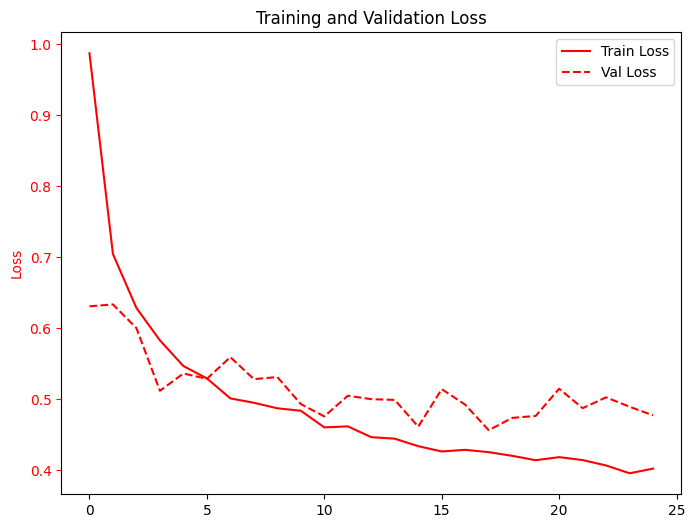

In [22]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.plot(history.history['loss'], 'r-', label='Train Loss')
ax2.plot(history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss')
plt.show()

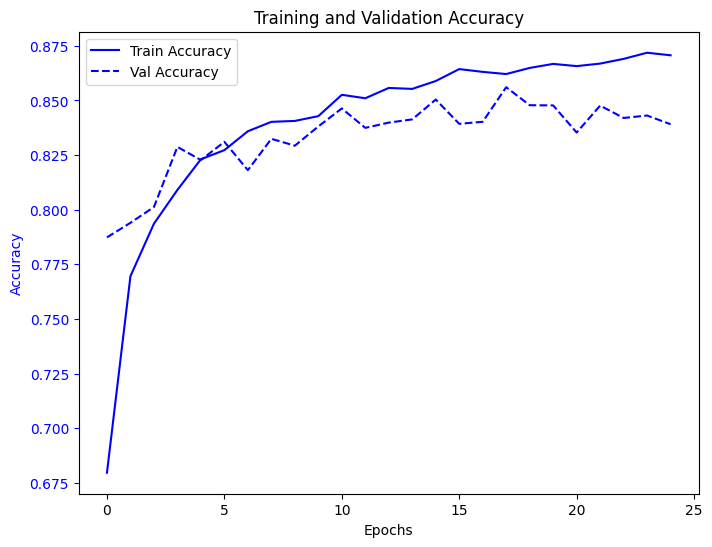

In [23]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
plt.title('Training and Validation Accuracy')
ax1.legend(loc='upper left')

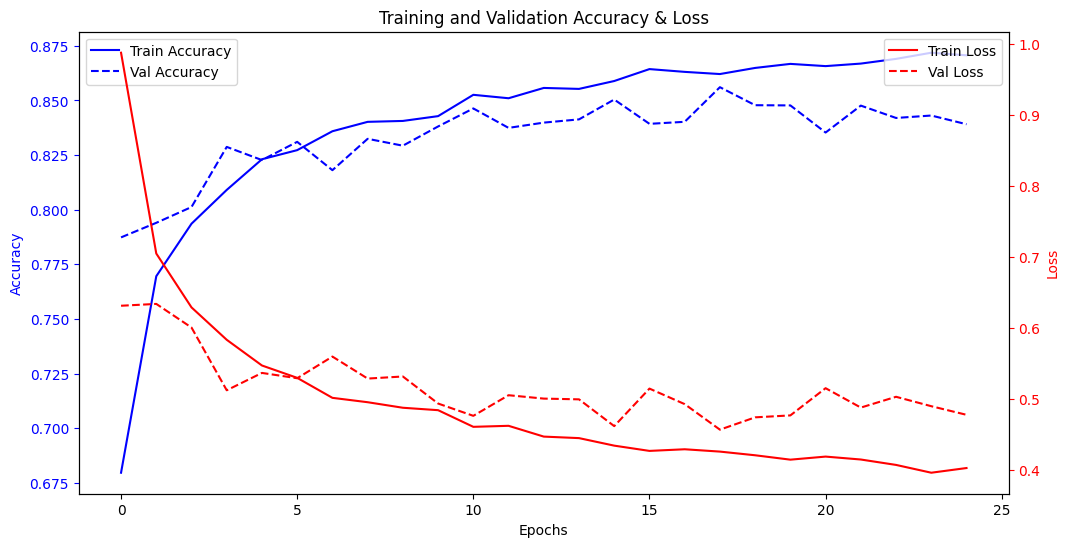

In [24]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy
ax1.plot(history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(history.history['loss'], 'r-', label='Train Loss')
ax2.plot(history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy & Loss')
plt.show()


338/338 ━━━━━━━━━━━━━━━━━━━━ 117s 341ms/step


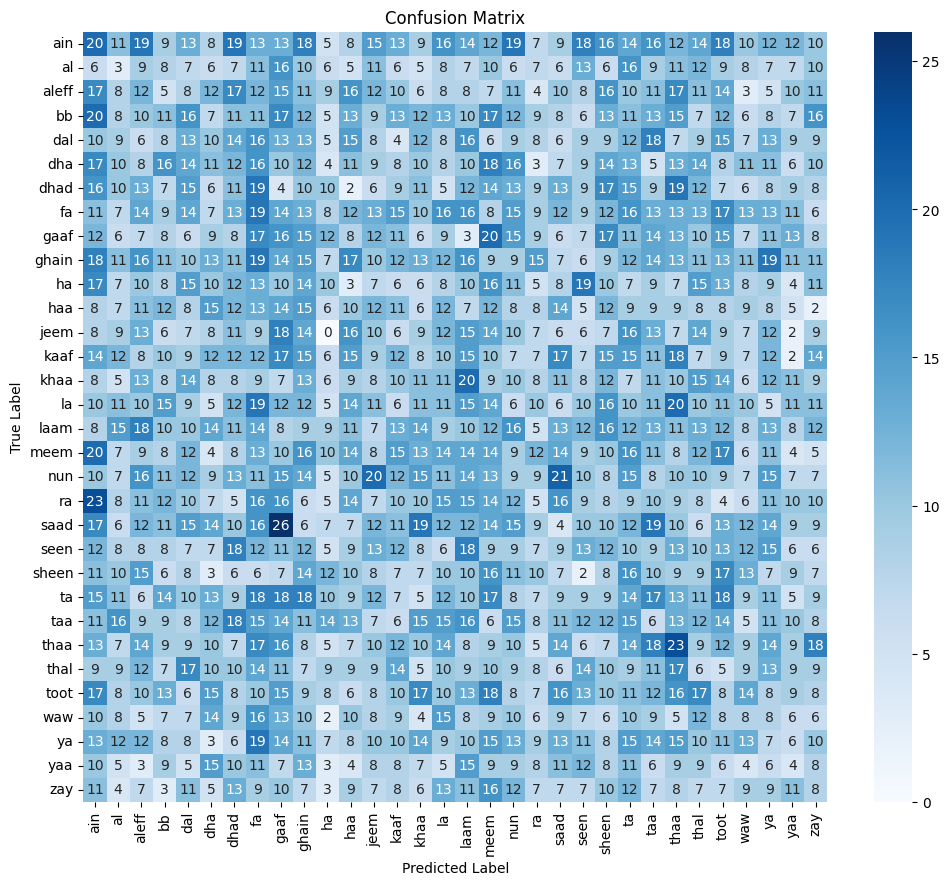

In [25]:
# Make predictions
y_pred = model.predict(val_data)   
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_data.classes   

categories = list(val_data.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [27]:
from sklearn.metrics import classification_report

# Validation data generator (for evaluation only)
val_data_eval = datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Predict again with correct order
y_pred = model.predict(val_data_eval)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_data_eval.classes

categories = list(val_data_eval.class_indices.keys())

print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

Found 10797 images belonging to 32 classes.
338/338 ━━━━━━━━━━━━━━━━━━━━ 112s 330ms/step

Classification Report:
              precision    recall  f1-score   support

         ain       0.95      0.95      0.95       422
          al       0.94      0.95      0.94       268
       aleff       0.93      0.97      0.95       334
          bb       0.88      0.73      0.80       358
         dal       0.84      0.81      0.83       326
         dha       0.95      0.82      0.88       344
        dhad       0.87      0.93      0.90       334
          fa       0.76      0.88      0.81       391
        gaaf       0.58      0.72      0.64       341
       ghain       0.89      0.88      0.88       395
          ha       0.85      0.60      0.70       318
         haa       0.76      0.89      0.82       305
        jeem       0.88      0.88      0.88       310
        kaaf       0.76      0.69      0.72       354
        khaa       0.88      0.79      0.83       321
          la       0.8

## EffecientNetB0

In [ ]:
# Evaluate the model on test data
val_loss, val_accuracy = Effecientnet_model.evaluate(val_data)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

In [ ]:
fig, ax2 = plt.subplots(figsize=(8, 6))
ax2.plot(effecientnet_history.history['loss'], 'r-', label='Train Loss')
ax2.plot(effecientnet_history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Loss')
plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accuracy
ax1.plot(effecientnet_history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(effecientnet_history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
plt.title('Training and Validation Accuracy')
ax1.legend(loc='upper left')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot accuracy
ax1.plot(effecientnet_history.history['accuracy'], 'b-', label='Train Accuracy')
ax1.plot(effecientnet_history.history['val_accuracy'], 'b--', label='Val Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='b')
ax1.tick_params('y', colors='b')
ax1.legend(loc='upper left')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.plot(effecientnet_history.history['loss'], 'r-', label='Train Loss')
ax2.plot(effecientnet_history.history['val_loss'], 'r--', label='Val Loss')
ax2.set_ylabel('Loss', color='r')
ax2.tick_params('y', colors='r')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy & Loss')
plt.show()

In [ ]:
y_pred = Effecientnet_model.predict(val_data)   
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_data.classes   

categories = list(val_data.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Validation data generator (for evaluation only)
val_data_eval = datagen.flow_from_directory(
    path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Predict again with correct order
y_pred = Effecientnet_model.predict(val_data_eval)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = val_data_eval.classes

categories = list(val_data_eval.class_indices.keys())

print('\nClassification Report:')
print(classification_report(y_true_classes, y_pred_classes, target_names=categories))

# **Model Save Operation**

In [28]:
# Save the trained model to an H5 file
model_save_path = '/kaggle/working/arabic_sign_language_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /kaggle/working/arabic_sign_language_model.h5


In [ ]:
# Save the trained model to an H5 file
model_save_path = '/kaggle/working/efficientnet_arasl_model.h5'
Effecientnet_model.save(model_save_path)
print(f"Model saved to {model_save_path}")